# АНАЛИЗ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ МОБИЛЬНОЙ ИГРЫ QUIZ FREEZE

## ЦЕЛЬ: исследовать поведение пользователей в обновлённом приложении

### ЗАДАЧИ:
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

### КОНКРЕТНЫЕ ШАГИ:
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

#### Подготовка данных 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Читаем данные из таблиц
events_df = pd.read_csv('data/7_4_Events.csv')
purchase_df = pd.read_csv('data/purchase.csv')

# Находим список пользователей, зарегистрировавшихся в 2018 году
cond = (events_df.start_time>='2018-01-01') & (events_df.start_time<'2019-01-01') & (events_df.event_type=='registration')
registered = events_df[cond]['user_id'].to_list() 
# Извлекаем пользователей, зарегистрировавшихся в 2018 году
events_df = events_df[events_df.user_id.isin(registered)] 
events_df.start_time = pd.to_datetime(events_df.start_time, format='%Y-%m-%dT%H:%M:%S')
purchase_df = purchase_df[purchase_df.user_id.isin(registered)]
purchase_df.event_datetime = pd.to_datetime(purchase_df.event_datetime, format='%Y-%m-%dT%H:%M:%S')

# добавим в датафрейм purchase_df столбец event_type, который будет содержать одно значение purchase
purchase_df['event_type'] = 'purchase'
# переименовываем столбцы id
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id"})
# объединяем датафреймы, сбрасываем индексы и сортируем по возрастанию времени
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

#### 1. Сравнение времени прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение

In [2]:
# Список пользователей, запустивших обучение
tutorial_start_users = total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].unique()
# Список пользователей, завершивших обучение
tutorial_finish_users = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique()
# Список пользователей, не завершивших обучение
not_finished_tutorial_users = (set(tutorial_start_users).difference(set(tutorial_finish_users)))
# Список пользователей, не начинавших обучение
not_started_tutorial_users = (set(total_events_df['user_id']).difference(set(tutorial_start_users)))

# Выделяем df для пользователей, завершивших обучение
finished_tutorial = total_events_df[total_events_df['user_id'].isin(tutorial_finish_users)]
# Определяем время регистрации  
registration_finished_tutorial = finished_tutorial[finished_tutorial['event_type'] == 'registration']
registration_finished_tutorial = registration_finished_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time':'registration_time'})
# Определяем время выбора уровня сложности
level_choice_finished_tutorial = finished_tutorial[finished_tutorial['event_type'] == 'level_choice']
level_choice_finished_tutorial = level_choice_finished_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time':'level_choice_time'})
# Определяем время выбора пакета вопросов
pack_choice_finished_tutorial = finished_tutorial[finished_tutorial['event_type'] == 'pack_choice']
pack_choice_finished_tutorial = pack_choice_finished_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time':'pack_choice_time'})
# Определяем время оплаты
purchase_finished_tutorial = finished_tutorial[finished_tutorial['event_type'] == 'purchase']
purchase_finished_tutorial = purchase_finished_tutorial[['user_id', 'event_datetime']].rename(
    columns={'event_datetime':'purchase_time'})
# Объединяем таблицы  
merged1_finished_tutorial = registration_finished_tutorial.merge(purchase_finished_tutorial, on= 'user_id', how= 'inner')
merged2_finished_tutorial = registration_finished_tutorial.merge(level_choice_finished_tutorial, on= 'user_id', how= 'inner')
merged3_finished_tutorial = level_choice_finished_tutorial.merge(pack_choice_finished_tutorial, on= 'user_id', how= 'inner')
merged4_finished_tutorial = pack_choice_finished_tutorial.merge(purchase_finished_tutorial, on= 'user_id', how= 'inner')

# Выделяем df для пользователей, не начинавших обучение
not_started_tutorial = total_events_df[total_events_df['user_id'].isin(not_started_tutorial_users)]
# Определяем время регистрации  
registration_not_started_tutorial = not_started_tutorial[not_started_tutorial['event_type'] == 'registration']
registration_not_started_tutorial = registration_not_started_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time':'registration_time'})
# Определяем время выбора уровня сложности
level_choice_not_started_tutorial = not_started_tutorial[not_started_tutorial['event_type'] == 'level_choice']
level_choice_not_started_tutorial = level_choice_not_started_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time':'level_choice_time'})
# Определяем время выбора пакета вопросов
pack_choice_not_started_tutorial = not_started_tutorial[not_started_tutorial['event_type'] == 'pack_choice']
pack_choice_not_started_tutorial = pack_choice_not_started_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time':'pack_choice_time'})
# Определяем время оплаты
purchase_not_started_tutorial = not_started_tutorial[not_started_tutorial['event_type'] == 'purchase']
purchase_not_started_tutorial = purchase_not_started_tutorial[['user_id', 'event_datetime']].rename(
    columns={'event_datetime':'purchase_time'})
# Объединяем таблицы  
merged1_not_started_tutorial = registration_not_started_tutorial.merge(
    purchase_not_started_tutorial, on= 'user_id', how= 'inner')
merged2_not_started_tutorial = registration_not_started_tutorial.merge(
    level_choice_not_started_tutorial, on= 'user_id', how= 'inner')
merged3_not_started_tutorial = level_choice_not_started_tutorial.merge(
    pack_choice_not_started_tutorial, on= 'user_id', how= 'inner')
merged4_not_started_tutorial = pack_choice_not_started_tutorial.merge(
    purchase_not_started_tutorial, on= 'user_id', how= 'inner')

# Вычисляем разницы во времени между событиями
merged1_finished_tutorial['timedelta'] = (merged1_finished_tutorial['purchase_time'] - merged1_finished_tutorial[
    'registration_time'])
print(
    'Среднее время между регистрацией и оплатой (для пользователей, прошедших обучение) : ', 
    merged1_finished_tutorial['timedelta'].mean())
merged1_not_started_tutorial['timedelta'] = (merged1_not_started_tutorial['purchase_time'] - merged1_not_started_tutorial[
    'registration_time'])
print(
    'Среднее время между регистрацией и оплатой (для пользователей, не начинавших обучение) : ', 
    merged1_not_started_tutorial['timedelta'].mean())

merged2_finished_tutorial['timedelta'] = (merged2_finished_tutorial['level_choice_time'] - merged2_finished_tutorial[
    'registration_time'])
print(
    'Среднее время между регистрацией и выбор уровня сложности (для пользователей, прошедших обучение) : ', 
    merged2_finished_tutorial['timedelta'].mean())
merged2_not_started_tutorial['timedelta'] = (merged2_not_started_tutorial['level_choice_time'] - merged2_not_started_tutorial[
    'registration_time'])
print(
    'Среднее время между регистрацией и выбор уровня сложности (для пользователей, не начинавших обучение) : ', 
    merged2_not_started_tutorial['timedelta'].mean())

merged3_finished_tutorial['timedelta'] = (merged3_finished_tutorial['pack_choice_time'] - merged3_finished_tutorial[
    'level_choice_time'])
print(
    'Среднее время между выбором уровня сложности и выбором пакета вопросов (для пользователей, прошедших обучение) : ', 
    merged3_finished_tutorial['timedelta'].mean())
merged3_not_started_tutorial['timedelta'] = (merged3_not_started_tutorial['pack_choice_time'] - merged3_not_started_tutorial[
    'level_choice_time'])
print(
    'Среднее время между выбором уровня сложности и выбором пакета вопросов (для пользователей, не начинавших обучение) : ', 
    merged3_not_started_tutorial['timedelta'].mean())

merged4_finished_tutorial['timedelta'] = (merged4_finished_tutorial['purchase_time'] - merged4_finished_tutorial[
    'pack_choice_time'])
print(
    'Среднее время между выбором пакета вопросов и оплатой (для пользователей, прошедших обучение) : ', 
    merged4_finished_tutorial['timedelta'].mean())
merged4_not_started_tutorial['timedelta'] = (merged4_not_started_tutorial['purchase_time'] - merged4_not_started_tutorial[
    'pack_choice_time'])
print(
    'Среднее время между выбором пакета вопросов и оплатой (для пользователей, не начинавших обучение) : ', 
    merged4_not_started_tutorial['timedelta'].mean())

Среднее время между регистрацией и оплатой (для пользователей, прошедших обучение) :  4 days 00:30:03.247408431
Среднее время между регистрацией и оплатой (для пользователей, не начинавших обучение) :  4 days 09:06:01.909090909
Среднее время между регистрацией и выбор уровня сложности (для пользователей, прошедших обучение) :  0 days 07:05:36.854819357
Среднее время между регистрацией и выбор уровня сложности (для пользователей, не начинавших обучение) :  0 days 05:15:33.122448979
Среднее время между выбором уровня сложности и выбором пакета вопросов (для пользователей, прошедших обучение) :  0 days 00:05:18.146058732
Среднее время между выбором уровня сложности и выбором пакета вопросов (для пользователей, не начинавших обучение) :  0 days 00:05:23.824324324
Среднее время между выбором пакета вопросов и оплатой (для пользователей, прошедших обучение) :  3 days 17:17:59.641326883
Среднее время между выбором пакета вопросов и оплатой (для пользователей, не начинавших обучение) :  4 days

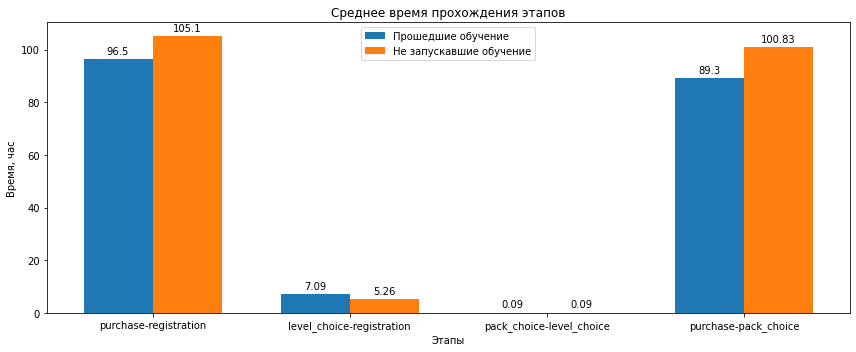

In [3]:
# Переводим значения timedelta в часа
timedelta1_1 = round(merged1_finished_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta1_2 = round(merged1_not_started_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta2_1 = round(merged2_finished_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta2_2 = round(merged2_not_started_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta3_1 = round(merged3_finished_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta3_2 = round(merged3_not_started_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta4_1 = round(merged4_finished_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
timedelta4_2 = round(merged4_not_started_tutorial['timedelta'].mean() / pd.Timedelta('1 hour'), 2)
# Построение визуализации
labels = ['purchase-registration', 'level_choice-registration', 'pack_choice-level_choice', 'purchase-pack_choice']
finished_tutorial  = [timedelta1_1, timedelta2_1, timedelta3_1, timedelta4_1]
not_started_tutorial = [timedelta1_2, timedelta2_2, timedelta3_2, timedelta4_2]
x = np.arange(len(labels))  
width = 0.35 
fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(x - width/2, finished_tutorial, width, label='Прошедшие обучение')
rects2 = ax.bar(x + width/2, not_started_tutorial, width, label='Не запускавшие обучение')
ax.set_xlabel('Этапы')
ax.set_ylabel('Время, час')
ax.set_title('Среднее время прохождения этапов')
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

##### Вывод: 
Время прохождения этапов игры пользователями зависит от того, проходили они обучение или нет. Этап от регистрации в игре, до покупки вопросов, в среднем на 8,6 часа быстрее проходят пользователи, которые прошли обучение. При том, что на обучение у них дополнительно в среднем уходит 1,83 часа, что показывает анализ этапа регистрация - выбор уровня сложности. Решение бесплатного пакета вопросов у пользователей, прошедших обучение происходит быстрее в среднем на 11,53 часа. Прохождение обучения улучшает взаимодействие пользователя с игрой и увеличивает его заинтересованность. Возможно необходимо рассмотреть вопрос о том, чтобы сделать этап обучения обязательным.  


#### 2. Проверка, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал пользователь 

In [4]:
# Пользователи, запустившие обучение
start_tutorial_user = total_events_df[total_events_df['event_type'] == 'tutorial_start']
# Считаем количество раз запуска обучения для каждого пользователя
user_groups_count_start = start_tutorial_user.groupby(['user_id'])['event_type'].agg(
    ['count']).sort_values('count', ascending=False).reset_index()

# Пользователи, совершившие покупку вопросов (клиенты)
paying_users = total_events_df[total_events_df['event_type'] == 'purchase']
paying_users = paying_users['user_id']

# Объединяем таблицы, для поиска клиентов
merged_start_tutorial_clients = user_groups_count_start.merge(paying_users, on= 'user_id', how= 'inner')
# Группируем клиентов, по количеству попыток начала обучения
start_tutorial_clients = merged_start_tutorial_clients.groupby(['count'])['user_id'].count().reset_index()
# Группируем пользователей, по количеству попыток начала обучения
start_tutorial_users = user_groups_count_start.groupby(['count'])['user_id'].count().reset_index()

# Переименовываем столбцы
start_tutorial_clients = start_tutorial_clients.rename(
    columns={'count':'count_start_tutorial', 'user_id':'count_clients'})
start_tutorial_users = start_tutorial_users.rename(
    columns={'count':'count_start_tutorial', 'user_id':'count_users'})
# Объединяем таблицы
merged_start_tutorial = start_tutorial_users.merge(start_tutorial_clients, on= 'count_start_tutorial', how= 'inner')
merged_start_tutorial['CR,%'] = round((merged_start_tutorial['count_clients'] / merged_start_tutorial['count_users'])*100, 2)
print(merged_start_tutorial)

   count_start_tutorial  count_users  count_clients   CR,%
0                     1         9103           1207  13.26
1                     2         1589            218  13.72
2                     3          427             51  11.94
3                     4          221             30  13.57
4                     5          109             16  14.68
5                     6          116             14  12.07
6                     7           94             12  12.77
7                     8           86             13  15.12
8                     9          113             17  15.04


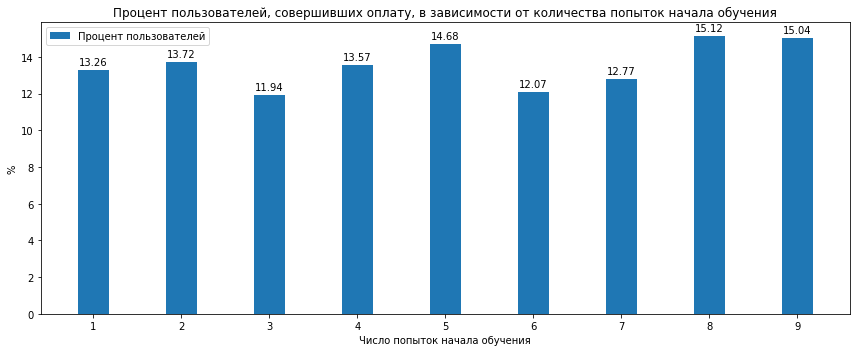

In [5]:
# Построение визуализации
labels = merged_start_tutorial['count_start_tutorial']
CR = merged_start_tutorial['CR,%']
x = np.arange(len(labels))  
fig, ax = plt.subplots(figsize=(12, 5))
rects = ax.bar(x, CR, width, label='Процент пользователей')
ax.set_xlabel('Число попыток начала обучения')
ax.set_ylabel('%')
ax.set_title('Процент пользователей, совершивших оплату, в зависимости от количества попыток начала обучения')
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(rects, padding=3)
fig.tight_layout()
plt.show()

##### Вывод:
Анализ показал, что количество попыток начала обучения мало влияет на вероятность оплаты пользователей. Процент оплаты пользователями вопросов между группами, сформированными на основании числа попыток начала обучения, отличается незначительно, не более 3,2%. 

#### 3. Определение, как часто пользователи начинают обучение после выбора уровня сложности

In [6]:
# Выделяем df для пользователей, запустивших обучение
start_tutorial = total_events_df[total_events_df['user_id'].isin(tutorial_start_users)]
# Определяем время начала обучения 
start_tutorial_time = start_tutorial[start_tutorial['event_type'] == 'tutorial_start']
start_tutorial_time = start_tutorial_time[['user_id', 'start_time']].rename(
    columns={'start_time':'start_tutorial_time'})
# Определяем время выбора уровня сложности
level_choice_time = start_tutorial[start_tutorial['event_type'] == 'level_choice']
level_choice_time = level_choice_time[['user_id', 'start_time']].rename(
    columns={'start_time':'level_choice_time'})
# Объединяем таблицы  
merged = start_tutorial_time.merge(level_choice_time, on= 'user_id', how= 'inner')
# Вычисляем разницы во времени между событиями
merged['timedelta'] = (merged['level_choice_time'] - merged['start_tutorial_time'])
# Количество пользователей, которые сначала запустили обучение, потом выбрали уровень сложности
users_tutorial_level = len(merged[merged['timedelta'] > pd.Timedelta(0)]['user_id'].unique())
print(
    "Количество пользователей, которые сначала запустили обучение, потом выбрали уровень сложности: ",
        users_tutorial_level
    )
# Количество пользователей, которые сначала выбрали уровень сложности, потом начали обучение
users_level_tutorial = len(merged[merged['timedelta'] < pd.Timedelta(0)]['user_id'].unique())
print(
    "Количество пользователей, которые сначала выбрали уровень сложности, потом начали обучение: ",
        users_level_tutorial
    )
percent_of_level_tutorial = users_level_tutorial / len(level_choice_time['user_id'])
print(
    "Процент пользователей (от выбравших уровень сложности), которые сначала выбрали уровень сложности,"
    "потом начали обучение: {:.2%}".format(
        percent_of_level_tutorial
    )
)

Количество пользователей, которые сначала запустили обучение, потом выбрали уровень сложности:  8244
Количество пользователей, которые сначала выбрали уровень сложности, потом начали обучение:  1386
Процент пользователей (от выбравших уровень сложности), которые сначала выбрали уровень сложности,потом начали обучение: 16.81%


##### Вывод:
Пользователи довольно часто начинают обучение после выбора уровня сложности, в 16,81% случаев. Необходима доработка приложения игры, чтобы сделать взаимодействие с ней более понятным для пользователя.